<a href="https://colab.research.google.com/github/VincentGaoHJ/Course-CS5242/blob/master/practice_5_convolutionalNeuralNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Practice 5: Convolutional Neural Networks

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch import optim
from tqdm.notebook import tqdm
import torchvision

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0')

**In this tutorial, we will learn about convolutional neural networks (CNNs). We will work on the MNIST dataset and make the last tutorials model better by using convolutional neural nets.**

Just like the last tutorial, we will start by defining the MNIST dataset. 

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]) 
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)

testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Q1. Initialize an MNist dataloader just like the last tutorial. Create a neural network model for classification with 


*   Convolution layer (16 channels, 3x3 kernel, stride 1, no padding)
*   Max-pooling layer (2x2 kernel, stride 1, no padding)
*   ReLU activation
*   Fully connected layer

Print the number of parameters for this network. Use cross-entropy loss, adam optimizer and train the model with multiple passes through the data and check the accuracy on the test set.


In [ ]:
class Net(nn.Module):
    
    









    



Number of parameter is 100170


In [ ]:
def accuracy(model, dataloader, device):
  
  






  




def train_model(model, criterion, optimizer, trainloader,
                testloader, num_epochs):
  
  









  

In [ ]:
train_model(MnistNet, criterion, optimizer, trainloader, testloader, num_epochs=5)


Epoch: 0, Training loss: 0.05, Train accuracy: 97.37, Test accuracy: 97.26



Epoch: 1, Training loss: 0.10, Train accuracy: 98.45, Test accuracy: 97.55



Epoch: 2, Training loss: 0.07, Train accuracy: 98.64, Test accuracy: 97.65



Epoch: 3, Training loss: 0.03, Train accuracy: 98.68, Test accuracy: 97.66



Epoch: 4, Training loss: 0.10, Train accuracy: 99.08, Test accuracy: 97.73



Epoch: 5, Training loss: 0.05, Train accuracy: 99.23, Test accuracy: 97.89


Q2. For a random sample of 5 digits (different digits), plot the first 10 convolution layer outputs (first 10 channels) and check it. (Tips: Use the member module, e.g., Net.conv1, or the hook)


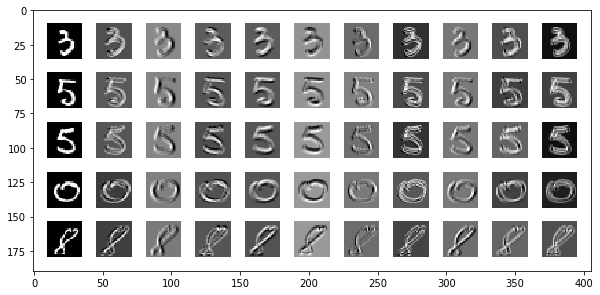

Q3. Use the first network from Q1 and then stack another layer of convolution after the max-pooling layer with a ReLU in between. Increase the number of channels to 64 for the next layer while keeping the kernel size to 3x3. Add batch norm and dropouts to your network. Print the parameter size. Train the network and print test accuracy.


In [ ]:
class Net(nn.Module):
    
    



















Number of parameter is 348138


In [ ]:
train_model(MnistNet, criterion, optimizer, trainloader, testloader, 5)


Epoch: 0, Training loss: 0.24, Train accuracy: 95.83, Test accuracy: 95.89



Epoch: 1, Training loss: 0.02, Train accuracy: 98.42, Test accuracy: 98.08



Epoch: 2, Training loss: 0.05, Train accuracy: 99.06, Test accuracy: 98.43



Epoch: 3, Training loss: 0.26, Train accuracy: 99.07, Test accuracy: 98.23



Epoch: 4, Training loss: 0.04, Train accuracy: 98.79, Test accuracy: 98.18



Epoch: 5, Training loss: 0.04, Train accuracy: 99.38, Test accuracy: 98.61


Q4. Visualize wrong predictions.  An important way to gain intuition about how the algorithm works are to visualize the mistakes that it makes. In this visualization, we show examples of images that are misclassified by our current system. 


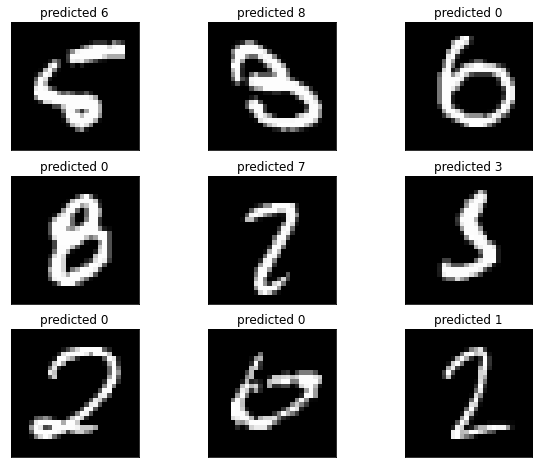

In [ ]:
wrong_images = []
predictions = []















wrong_images_9 = wrong_images[:10,:,:,:]
predictions_9 = predictions[:10]

from matplotlib import pyplot as plt
fig, axes = plt.subplots(nrows=3, ncols=3)

for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.imshow(wrong_images_9[i][0])
  plt.title('predicted '+str(predictions_9[i]))
  plt.xticks([])
  plt.yticks([])

Q5. Use the pytorch pre-trained resnet18 model with fine-tuning to classify Cifar10 data and print its train and test accuracy.

**Hint**:

- Using Pytorch pre-trained resnet18 model: [https://pytorch.org/docs/stable/torchvision/models.html](https://pytorch.org/docs/stable/torchvision/models.html).

- For fine-tuning, you can have a look at [How to fine-tune your artificial intelligence algorithms](https://www.allerin.com/blog/how-to-fine-tune-your-artificial-intelligence-algorithms).


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])










Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
from torchvision.models import resnet18





















train_model(cifar10_resnet, criterion, optimizer, trainloader, testloader, 5)
print('Test Accuracy is %.2f'%accuracy(cifar10_resnet, testloader, device))

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



Number of parameter is 11181642



Epoch: 0, Training loss: 0.69, Train accuracy: 82.11, Test accuracy: 75.48



Epoch: 1, Training loss: 0.51, Train accuracy: 89.37, Test accuracy: 78.79



Epoch: 2, Training loss: 0.42, Train accuracy: 93.46, Test accuracy: 79.08



Epoch: 3, Training loss: 0.33, Train accuracy: 96.20, Test accuracy: 79.68



Epoch: 4, Training loss: 0.22, Train accuracy: 97.62, Test accuracy: 80.05



Epoch: 5, Training loss: 0.18, Train accuracy: 98.21, Test accuracy: 79.93



Test Accuracy is 79.93
